In [1]:
from nilearn import datasets
print('Datasets are stored in: %r' % datasets.get_data_dirs())

Datasets are stored in: ['/Users/anischihoub/nilearn_data']


/Users/anischihoub/.local/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
motor_images = datasets.fetch_neurovault_motor_task()
motor_images.images
tmap_filename = motor_images.images[0]

/Users/anischihoub/.local/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:341: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


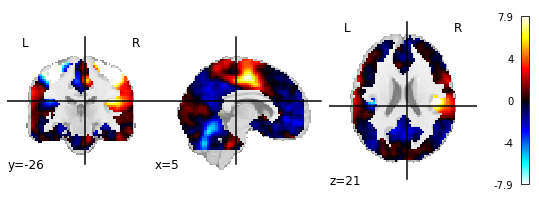

In [3]:
from nilearn import plotting
plotting.plot_stat_map(tmap_filename)


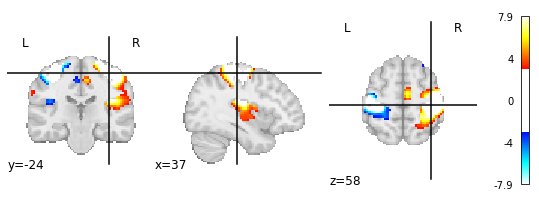

In [4]:
disp = plotting.plot_stat_map(tmap_filename, threshold=3)

In [5]:
disp.savefig('pretty_brain.png')

Useful Links:
https://nilearn.github.io/stable/plotting/index.html

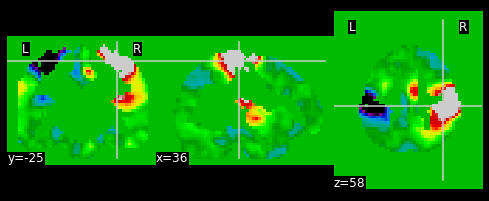

In [6]:

plotting.plot_epi(tmap_filename)

Covariance Matrix

In [7]:
atlas = datasets.fetch_atlas_msdl()
# Loading atlas image stored in 'maps'
atlas_filename = atlas['maps']
# Loading atlas data stored in 'labels'
labels = atlas['labels']

# Loading the functional datasets
data = datasets.fetch_development_fmri(n_subjects=1)

/Users/anischihoub/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/npyio.py:2405: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [8]:
from nilearn.input_data import NiftiMapsMasker
masker = NiftiMapsMasker(maps_img=atlas_filename, standardize=True,
                         memory='nilearn_cache', verbose=5)

time_series = masker.fit_transform(data.func[0],
                                   confounds=data.confounds)

[NiftiMapsMasker.fit_transform] loading regions from /Users/anischihoub/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/Users/anischihoub/.local/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


Resampling maps
[Memory]0.1s, 0.0min    : Loading resample_img...
________________________________________resample_img cache loaded - 0.0s, 0.0min
[Memory]0.2s, 0.0min    : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/Users/anischihoub/.local/lib/python3.9/site-packages/nilearn/_utils/cache_mixin.py:303: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


In [9]:
try:
    from sklearn.covariance import GraphicalLassoCV
except ImportError:
    # for Scitkit-Learn < v0.20.0
    from sklearn.covariance import GraphLassoCV as GraphicalLassoCV

estimator = GraphicalLassoCV()
estimator.fit(time_series)

GraphicalLassoCV()

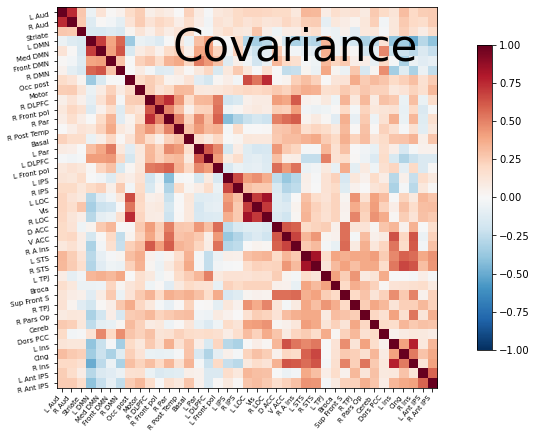

In [10]:
from nilearn import plotting
# Display the covariance

# The covariance can be found at estimator.covariance_
plotting.plot_matrix(estimator.covariance_, labels=labels,
                     figure=(9, 7), vmax=1, vmin=-1,
                     title='Covariance')


In [11]:
from sklearn.covariance import empirical_covariance
import numpy as np
time_series.shape
cov = empirical_covariance(time_series)

In [12]:
from sklearn.linear_model import lars_path_gram
from sklearn.preprocessing import StandardScaler
def fit_3(X,p = 0.01,maxItr=1000, tol=1e-2,alpha=.055,eps=1e-2):
    #get the dimensions of the n by d time series matrix
    n_samples,n_features=X.shape[0],X.shape[1]
    
    #privacy parameters
    epsilon = 1e-5
    delta = 1e-7
    c2 = 2*np.log(1.25/delta)
    
    # sample covariance S = X'X/n;
    scaler=StandardScaler().fit(X)
    X=scaler.transform(X)
    S=X.T.dot(X)/n_samples
    
    #Set up precision matrix
    precision = np.linalg.pinv(S)
    sub_covariance = np.copy(S[1:, 1:], order="C")
    
    #Create an empirical covariance
    covariance = S.copy()
    
    #list of indices for row column selection
    indices = np.arange(n_features)
    
    #training loop
    for i in range(maxItr):
        for idx in range(n_features):
            #if our current index is not 0, we pick elements from the subcovariance matrix not in row,col idx
            if idx > 0:
                di = idx - 1
                sub_covariance[di] = covariance[di][indices != idx]
                sub_covariance[:, di] = covariance[:, di][indices != idx]
            else:
            #if our current index is 0, we just pick everything that is beyond the first row and column
                sub_covariance[:] = covariance[1:, 1:]
            #inner product
            row = S[idx, indices != idx]
            #Solve the lasso problem for each index
            _, _, coefs = lars_path_gram(
                            Xy=row,
                            Gram=sub_covariance,
                            n_samples=row.size,
                            alpha_min=alpha / (n_features - 1),
                            copy_Gram=True,
                            eps=eps,
                            method="lars",
                            return_path=False,
                        )
            #We make updates to the precision and covariance matrices. 
            precision[indices != idx, idx] = -precision[idx, idx] * coefs
            precision[idx, indices != idx] = -precision[idx, idx] * coefs
            coefs = np.dot(sub_covariance, coefs)
            covariance[idx, indices != idx] = coefs
            covariance[indices != idx, idx] = coefs
            
            
    return precision, covariance

In [13]:
A,B = fit_3(time_series)

In [14]:
estimator.alpha_

0.028245493133697428

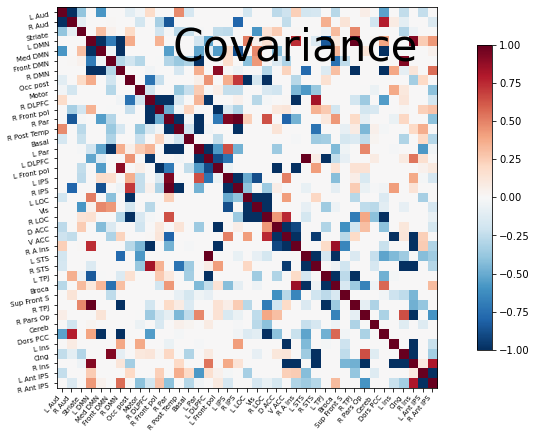

In [15]:
# The covariance can be found at estimator.covariance_
plotting.plot_matrix(A, labels=labels,
                     figure=(9, 7), vmax=1, vmin=-1,
                     title='Covariance')

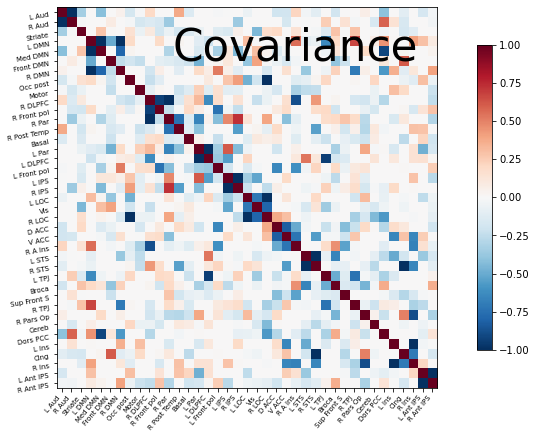

In [16]:
# The covariance can be found at estimator.covariance_
import matplotlib.cm as cm
plotting.plot_matrix(estimator.precision_, labels=labels,
                     figure=(9, 7), vmax=1, vmin=-1,
                     title='Covariance',)

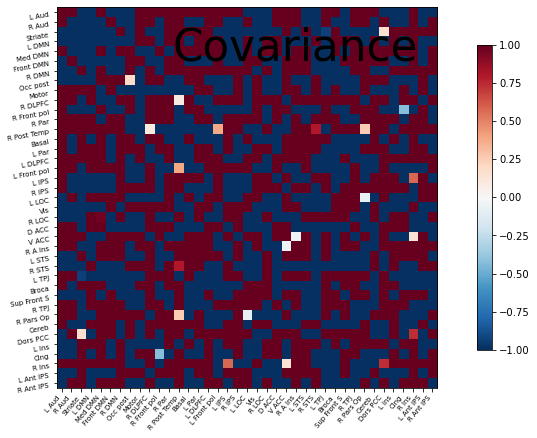

In [17]:
#privacy parameters, this is the gaussian noise approach defined in the Dwork paper. Double check if we need to do this per iteration or if one time will suffice.
epsilon = .1
delta = 1e-7
c2 = np.sqrt(2*np.log(1.25/delta))/epsilon

nse_mat = np.random.normal(0,scale =c2,size = [time_series.shape[1],time_series.shape[1]])
upper_nse_mat = np.triu(nse_mat, 0)
lower_triangle = np.triu(nse_mat,1)
upper_nse_mat = upper_nse_mat + lower_triangle.transpose()


new_covs = (estimator.precision_)+upper_nse_mat
# The covariance can be found at estimator.covariance_
plotting.plot_matrix(new_covs, labels=labels,
                     figure=(9, 7), vmax=1, vmin=-1,
                     title='Covariance')


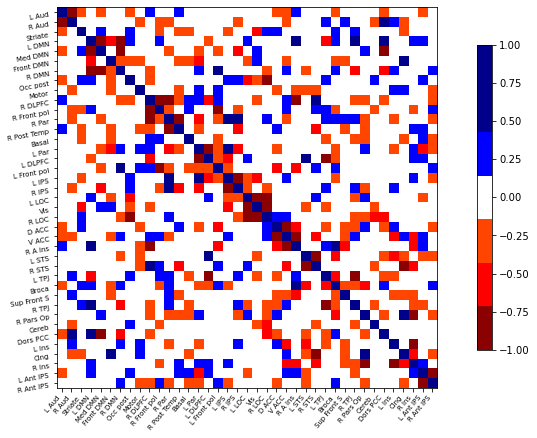

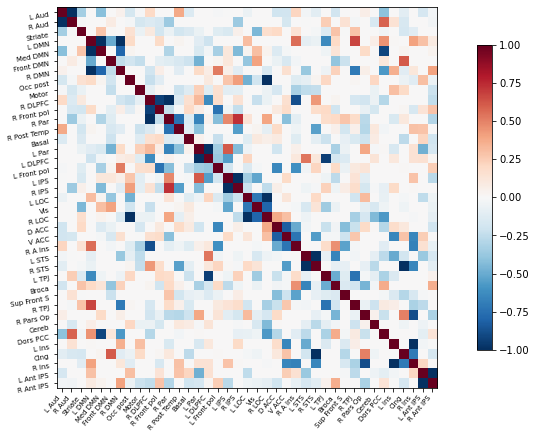

In [18]:
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as colors
cmap = ListedColormap(["darkred", "red","orangered","white","blue","darkblue","darkblue"])


out = plotting.plot_matrix(estimator.precision_, labels=labels,
                     figure=(9, 7), vmax=1, vmin=-1,
                     cmap=cmap)
plotting.plot_matrix(estimator.precision_, labels=labels,
                     figure=(9, 7), vmax=1, vmin=-1,
                     )

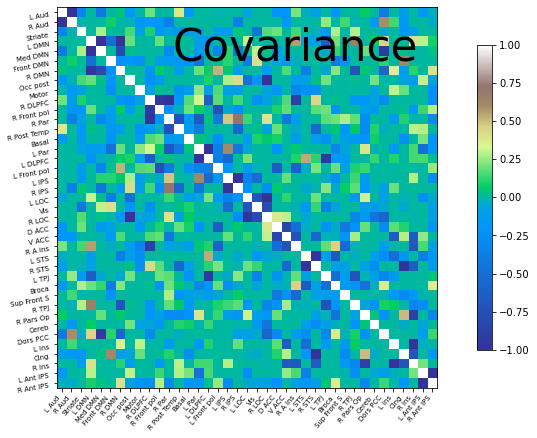

In [19]:
#we can overwrite the color map here, we just need to generate it somehow. 
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as colors
cmap = ListedColormap(["darkorange", "gold", "lawngreen","white", "lightseagreen","Red","Black"])
ax = out.axes
colors_undersea = cm.terrain(np.linspace(0, 0.17, 8))
colors_land = cm.terrain(np.linspace(0.25, 1, 8))
all_colors = np.vstack((colors_undersea, colors_land))
terrain_map = colors.LinearSegmentedColormap.from_list(
    'terrain_map', all_colors)

out = plotting.plot_matrix(estimator.precision_, labels=labels,
                     figure=(9, 7), vmax=1, vmin=-1,
                     title='Covariance',cmap=terrain_map)

Linearly Segmented Colormap

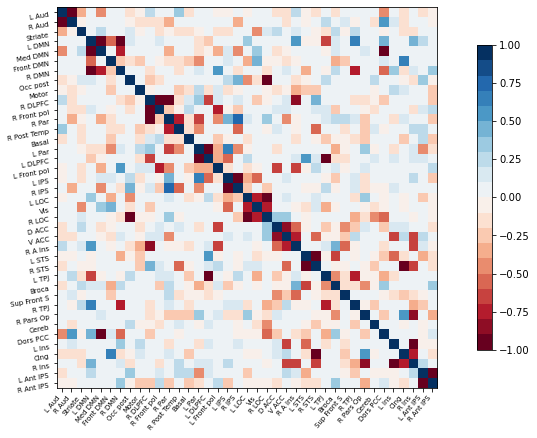

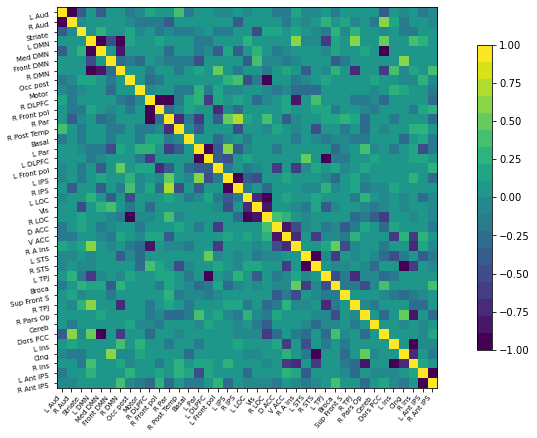

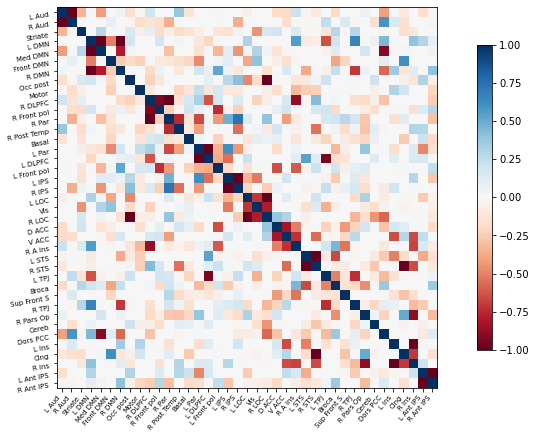

In [20]:
cdict = {'red':   [[0.0,  0.0, 0.0],
                   [0.5,  1.0, 1.0],
                   [1.0,  1.0, 1.0]],
         'green': [[0.0,  0.0, 0.0],
                   [0.25, 0.0, 0.0],
                   [0.75, 1.0, 1.0],
                   [1.0,  1.0, 1.0]],
         'blue':  [[0.0,  0.0, 0.0],
                   [0.5,  0.0, 0.0],
                   [1.0,  1.0, 1.0]]}

viridis = cm.get_cmap('RdBu', 20)
newcolors = viridis(np.linspace(0, 1, 20))
newcmp = ListedColormap(newcolors)
out = plotting.plot_matrix(estimator.precision_, labels=labels,
                     figure=(9, 7), vmax=1, vmin=-1,
                     cmap=newcmp)


viridis = cm.get_cmap('viridis', 18)
newcolors = viridis(np.linspace(0, 1, 18))
newcmp = ListedColormap(newcolors)
out = plotting.plot_matrix(estimator.precision_, labels=labels,
                     figure=(9, 7), vmax=1, vmin=-1,
                     cmap=newcmp)

viridis = cm.get_cmap('RdBu', 256)
newcolors = viridis(np.linspace(0, 1, 256))
newcmp = ListedColormap(newcolors)
out = plotting.plot_matrix(estimator.precision_, labels=labels,
                     figure=(9, 7), vmax=1, vmin=-1,
                     cmap=newcmp)

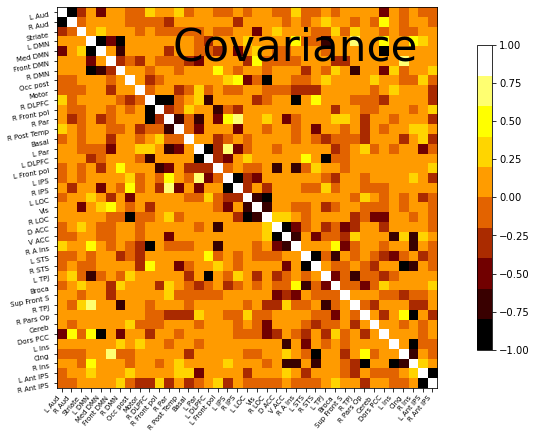

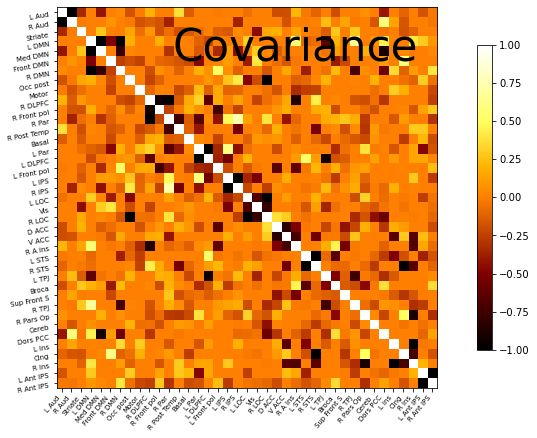

In [21]:
#N is a quantization level
cdict = {'red':   [[0.0,  0.0, 0.0],
                   [0.5,  1.0, 1.0],
                   [1.0,  1.0, 1.0]],
         'green': [[0.0,  0.0, 0.0],
                   [0.25, 0.0, 0.0],
                   [0.75, 1.0, 1.0],
                   [1.0,  1.0, 1.0]],
         'blue':  [[0.0,  0.0, 0.0],
                   [0.8,  0.0, 0.0],
                   [1.0,  1.0, 1.0]]}
newcmp = LinearSegmentedColormap('testCmap', segmentdata=cdict, N=10)
rgba = newcmp(np.linspace(0, 1, 10))
newcmp = ListedColormap(rgba)
out = plotting.plot_matrix(estimator.precision_, labels=labels,
                     figure=(9, 7), vmax=1, vmin=-1,
                     title='Covariance',cmap=newcmp)






#N is a quantization level
cdict = {'red':   [[0.0,  0.0, 0.0],
                   [0.5,  1.0, 1.0],
                   [1.0,  1.0, 1.0]],
         'green': [[0.0,  0.0, 0.0],
                   [0.25, 0.0, 0.0],
                   [0.75, 1.0, 1.0],
                   [1.0,  1.0, 1.0]],
         'blue':  [[0.0,  0.0, 0.0],
                   [0.6,  0.0, 0.0],
                   [1.0,  1.0, 1.0]]}
newcmp = LinearSegmentedColormap('testCmap', segmentdata=cdict, N=256)
rgba = newcmp(np.linspace(0, 1, 256))
newcmp = ListedColormap(rgba)
out = plotting.plot_matrix(estimator.precision_, labels=labels,
                     figure=(9, 7), vmax=1, vmin=-1,
                     title='Covariance',cmap=newcmp)

Idea #1: Multiple data sets with their covariances:

Non-Linear Colormap

/Users/anischihoub/.local/lib/python3.9/site-packages/nilearn/plotting/matrix_plotting.py:161: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  display = axes.imshow(mat, aspect='equal', interpolation='nearest',


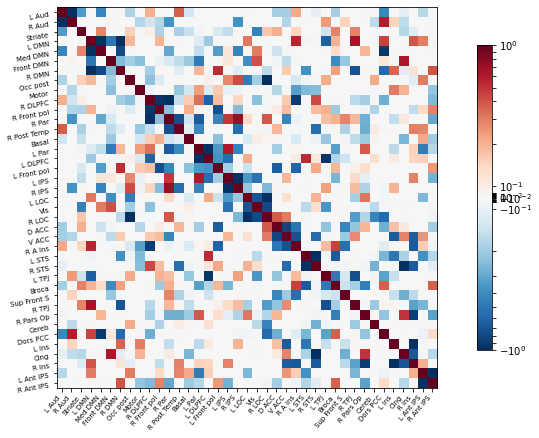

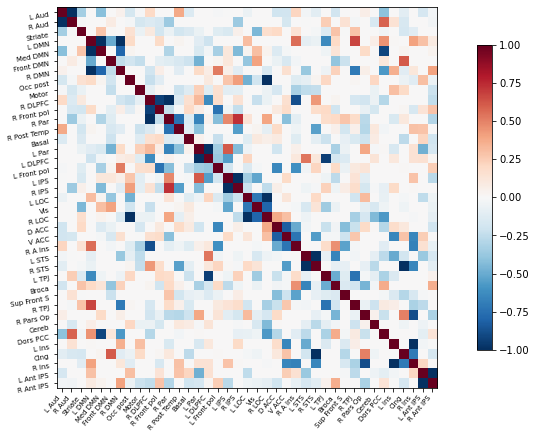

In [22]:
import numpy as np
import matplotlib.pyplot as plt


plotting.plot_matrix(estimator.precision_, labels=labels,
                     figure=(9, 7), vmax=1, vmin=-1,
                  cmap = "RdBu_r",norm=colors.SymLogNorm(linthresh=.09, linscale=0.03,
                                              vmin=-1.0, vmax=1.0))

plotting.plot_matrix(estimator.precision_, labels=labels,
                     figure=(9, 7), vmax=1, vmin=-1,
                    )

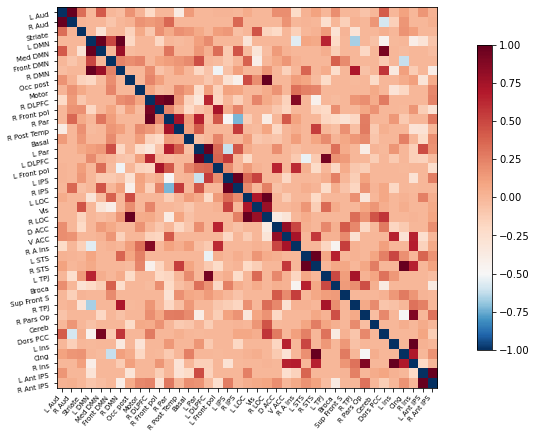

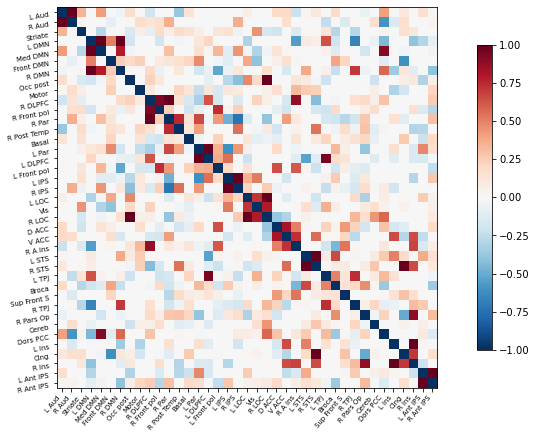

In [23]:
import numpy as np
import matplotlib.pyplot as plt
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))


plotting.plot_matrix(-estimator.precision_, labels=labels,
                     figure=(9, 7), vmax=1, vmin=-1,
                  cmap = "RdBu_r",norm=MidpointNormalize(midpoint=-0.5))

plotting.plot_matrix(-estimator.precision_, labels=labels,
                     figure=(9, 7), vmax=1, vmin=-1,
                    )

(168, 39)
(167, 39)


/Users/anischihoub/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:229: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


(39, 39)


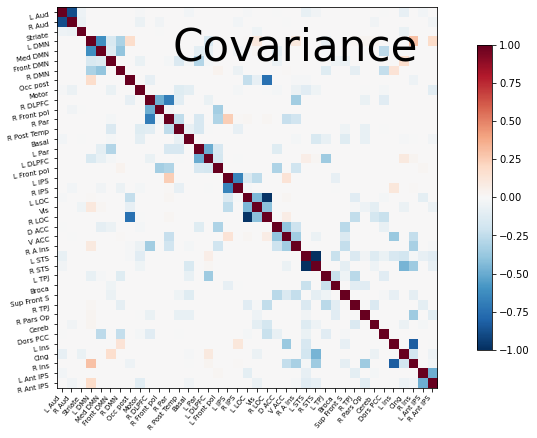

In [24]:
estimator = GraphicalLassoCV()
estimator.fit(time_series)
print(time_series.shape)
new_data = np.delete(time_series, 0, axis=0)
print(new_data.shape)
estimator.fit(new_data)
plotting.plot_matrix(estimator.precision_, labels=labels,
                     figure=(9, 7), vmax=1, vmin=-1,
                     title='Covariance')
print(estimator.precision_.shape)
#one indiviudal or multiple?
#privacy piece

Loading Datasets

In [25]:
data = datasets.fetch_development_fmri(n_subjects=155)

Correlation Plots

In [43]:
from nilearn import datasets
import matplotlib.cm as cm

msdl_data = datasets.fetch_atlas_msdl()
msdl_coords = msdl_data.region_coords
n_regions = len(msdl_coords)
labels = msdl_data["labels"]

TypeError: fetch_atlas_msdl() got an unexpected keyword argument 'n_subjects'

In [27]:
from nilearn import input_data

masker = input_data.NiftiMapsMasker(
    msdl_data.maps, resampling_target="data", t_r=2, detrend=True,
    low_pass=.1, high_pass=.01, memory='nilearn_cache', memory_level=1).fit()

/Users/anischihoub/.local/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


In [28]:
#multiple subjects
#add noise to time_series, then filter
#local sensitivity experiment (remove individual)
#Dithered quantization: little bit of noise + then quantize (not very private, but maybe some inspiration to be had)
#check sensitivity (see above)
#clean up this note
pooled_subjects = []
development_dataset = datasets.fetch_development_fmri(n_subjects=30)
for func_file, confound_file, phenotypic in zip(
        development_dataset.func,
        development_dataset.confounds,
        development_dataset.phenotypic):
    time_series = masker.transform(func_file, confounds=confound_file)
    pooled_subjects.append(time_series)

In [29]:
from nilearn.connectome import ConnectivityMeasure

correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrices = correlation_measure.fit_transform(pooled_subjects)

In [30]:
mean_correlation_matrix = correlation_measure.mean_

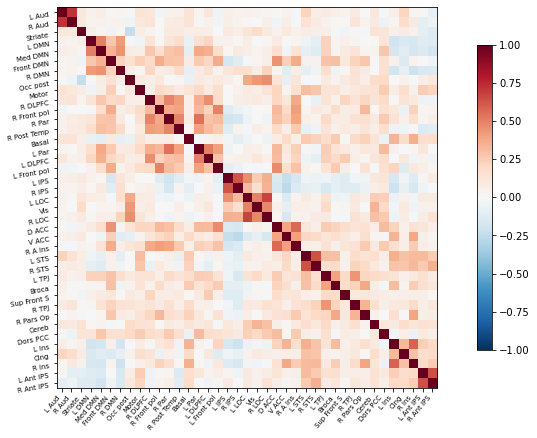

In [31]:
plotting.plot_matrix(mean_correlation_matrix, 
                     figure=(9, 7), vmax=1, vmin=-1,
                     labels = labels)

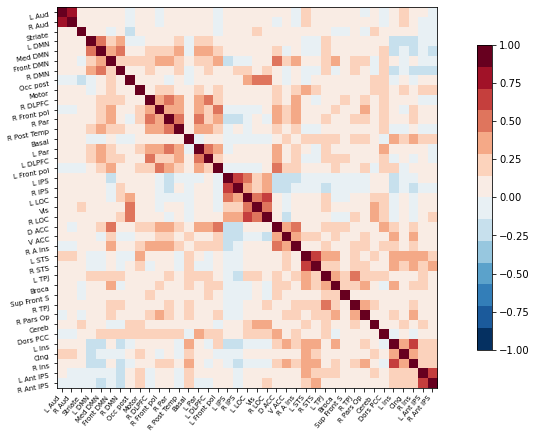

In [32]:
import numpy as np
viridis = cm.get_cmap('RdBu_r', 14)
newcolors = viridis(np.linspace(0, 1, 14))
newcmp = ListedColormap(newcolors)
plotting.plot_matrix(mean_correlation_matrix, 
                     figure=(9, 7), vmax=1, vmin=-1,
                     labels = labels,cmap = newcmp)

/Users/anischihoub/.local/lib/python3.9/site-packages/nilearn/plotting/matrix_plotting.py:161: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  display = axes.imshow(mat, aspect='equal', interpolation='nearest',


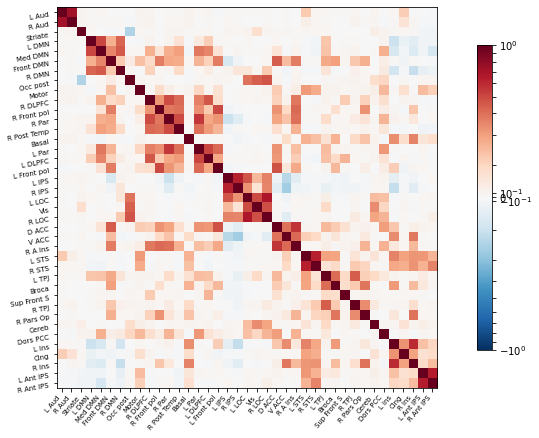

In [33]:
plotting.plot_matrix(mean_correlation_matrix, labels=labels,
                     figure=(9, 7), vmax=1, vmin=-1,
                  cmap = "RdBu_r",norm=colors.SymLogNorm(linthresh=.14, linscale=0.03,
                                              vmin=-1.0, vmax=1.0))
#randomize assignment of colors?
#

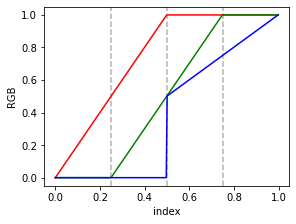

In [34]:
#change the mapping
cdict = {'red':   [[0.0,  0.0, 0.0],
                   [0.5,  1.0, 1.0],
                   [1.0,  1.0, 1.0]],
         'green': [[0.0,  0.0, 0.0],
                   [0.25, 0.0, 0.0],
                   [0.75, 1.0, 1.0],
                   [1.0,  1.0, 1.0]],
         'blue':  [[0.0,  0.0, 0.0],
                   [0.5,  0.0, 0.5],
                   [1.0,  1.0, 1.0]]}


#y left and y right and the "limits" when approaching and leaving that point
#Choice of color map and underlying data
# We need the possible tools first 
def plot_linearmap(cdict):
    newcmp = LinearSegmentedColormap('testCmap', segmentdata=cdict, N=256)
    rgba = newcmp(np.linspace(0, 1, 256))
    fig, ax = plt.subplots(figsize=(4, 3), constrained_layout=True)
    col = ['r', 'g', 'b']
    for xx in [0.25, 0.5, 0.75]:
        ax.axvline(xx, color='0.7', linestyle='--')
    for i in range(3):
        ax.plot(np.arange(256)/256, rgba[:, i], color=col[i])
    ax.set_xlabel('index')
    ax.set_ylabel('RGB')
    plt.show()

plot_linearmap(cdict)

In [35]:
# datasets = {}
# old = pooled_subjects
# for i in range(len(pooled_subjects)):
#     temp = pooled_subjects.pop(i)
#     pooled_subjects = old
#     datasets[i] = temp

data = pooled_subjects.pop(3)

In [38]:
correlation_measure2 = ConnectivityMeasure(kind='correlation')
correlation_matrices2 = correlation_measure2.fit_transform(pooled_subjects)

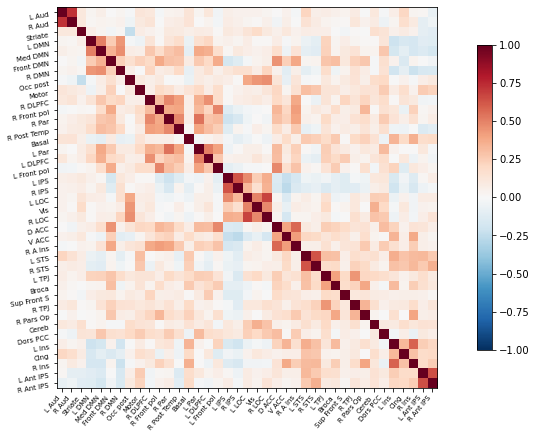

In [39]:
mean_correlation_matrix2 = correlation_measure2.mean_
plotting.plot_matrix(mean_correlation_matrix2, 
                     figure=(9, 7), vmax=1, vmin=-1,
                     labels = labels)

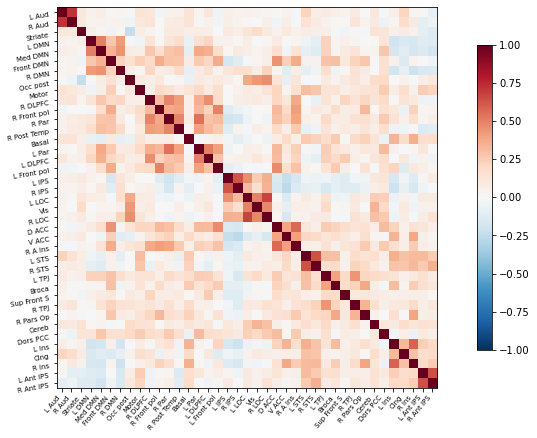

In [42]:
plotting.plot_matrix(mean_correlation_matrix, 
                     figure=(9, 7), vmax=1, vmin=-1,
                     labels = labels)